In [1]:
import pandas as pd
from itertools import islice
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import seaborn as sn
sn.set_theme(style="white", palette="rocket_r")

In [43]:
y_train = np.load('y_train_static_12.npy')

In [44]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([5906, 1327]))

In [5]:
cd ..

/home/jesu3767/Desktop/eICU


In [3]:
# Process the time-series
def timeseries_processing(timeseries, labels, hour):
    timeseries.reset_index(level=1, inplace=True)
    timeseries.time = pd.to_timedelta(timeseries.time, errors='coerce')
    
    # Convert the time-stamps into minutes
    timeseries.time = timeseries.time.astype(int)/(1000000000*60)
        
    # Add time of event
    timeseries = timeseries.merge(labels, left_index=True, right_index=True)
    
    # Only keep those timestamps with more than time before the event for prediction
    timeseries = timeseries[timeseries['time'] <= (timeseries['unitdischargeoffset'] - hour*60)]
    
    # Drop the labels column, we will add them at the end for consistency and to avoid redundancy
    timeseries = timeseries.drop(columns=['unitdischargeoffset', 'predictedhospitalmortality', 'actualhospitalmortality'])
    
    timeseries.reset_index(inplace=True)
    timeseries.set_index(['patient', 'time'], inplace=True)
    
    # Get the means and standard deviations of the timeseries
    df_mean = pd.concat({'mean': timeseries.groupby(level=0, axis=0).mean()}, axis=1).swaplevel(axis=1)
    df_mean.columns = df_mean.columns.droplevel(level = 1)
    df_mean = df_mean.add_suffix('_mean')

    df_std = pd.concat({'std': timeseries.groupby(level=0, axis=0).std()}, axis=1).swaplevel(axis=1)
    df_std.columns = df_std.columns.droplevel(level = 1)
    df_std = df_std.add_suffix('_std')

    timeseries = df_mean.merge(df_std, left_index=True, right_index=True)
    
    return timeseries

In [75]:
labels = pd.read_csv('Data/preprocessed_labels.csv', index_col='patient')

In [76]:
columns_that_matter = ['unitdischargeoffset', 'predictedhospitalmortality', 'actualhospitalmortality']
labels = labels[columns_that_matter]

In [77]:
labels

,unitdischargeoffset,predictedhospitalmortality,actualhospitalmortality
patient,,,
141168,3596,0.059099,1
141194,4813,0.102283,0
141203,1869,0.470973,0
141208,720,0.002249,0
141227,1652,0.488562,0
...,...,...,...
3353235,1069,0.022630,0
3353237,1269,0.062568,0
3353251,16259,0.918169,0


# Respiratory Variables

In [7]:
timeseries_resp = pd.read_csv('Data/timeseries_resp.csv', index_col=['patient', 'time'])

In [8]:
timeseries_resp

Exhaled MV  Exhaled TV (patient)  FiO2  LPM O2  \
patient time                                                                
141168  0 days 06:36:00           NaN                   NaN   NaN     4.0   
        0 days 09:23:00           NaN                   NaN   NaN     4.0   
        0 days 10:06:00           NaN                   NaN   NaN     4.0   
        0 days 11:06:00           NaN                   NaN   NaN     4.0   
        0 days 12:06:00           NaN                   NaN   NaN     4.0   
...                               ...                   ...   ...     ...   
3353251 7 days 21:43:00           NaN                   NaN  40.0     NaN   
        7 days 22:23:00           NaN                 525.0  40.0     NaN   
        7 days 22:43:00           NaN                   NaN  40.0     NaN   
3353254 -1 days +20:21:00         NaN                   NaN   NaN     NaN   
        0 days 01:59:00           NaN                   NaN   NaN     NaN   

                           Mean Airway Pressure  PEEP  Peak Insp. Pressure  \
patient time                                                                 
141168  0 days 06:36:00                     NaN   NaN                  NaN   
        0 days 09:23:00                     NaN   NaN                  NaN   
        0 days 10:06:00                     NaN   NaN                  NaN   
        0 days 11:06:00                     NaN   NaN                  NaN   
        0 days 12:06:00                     NaN   NaN                  NaN   
...                                         ...   ...                  ...   
3353251 7 days 21:43:00                     NaN   8.0                  NaN   
        7 days 22:23:00                     NaN   8.0                 16.0   
        7 days 22:43:00                     NaN   8.0                  NaN   
3353254 -1 days +20:21:00                   NaN   NaN                  NaN   
        0 days 01:59:00                     NaN   NaN                  NaN   

                           Plateau Pressure  Pressure Support  RR (patient)  \
patient time                                                                  
141168  0 days 06:36:00                 NaN               NaN           NaN   
        0 days 09:23:00                 NaN               NaN           NaN   
        0 days 10:06:00                 NaN               NaN           NaN   
        0 days 11:06:00                 NaN               NaN           NaN   
        0 days 12:06:00                 NaN               NaN           NaN   
...                                     ...               ...           ...   
3353251 7 days 21:43:00                 NaN               NaN           NaN   
        7 days 22:23:00                 NaN               7.0           NaN   
        7 days 22:43:00                 NaN               7.0           NaN   
3353254 -1 days +20:21:00               NaN               NaN           NaN   
        0 days 01:59:00                 NaN               NaN           NaN   

                           SaO2  TV/kg IBW  Tidal Volume (set)  Total RR  \
patient time                                                               
141168  0 days 06:36:00     NaN        NaN                 NaN       NaN   
        0 days 09:23:00     NaN        NaN                 NaN       NaN   
        0 days 10:06:00     NaN        NaN                 NaN       NaN   
        0 days 11:06:00     NaN        NaN                 NaN       NaN   
        0 days 12:06:00     NaN        NaN                 NaN       NaN   
...                         ...        ...                 ...       ...   
3353251 7 days 21:43:00     NaN        NaN                 NaN       NaN   
        7 days 22:23:00     NaN        NaN                 NaN       NaN   
        7 days 22:43:00     NaN        NaN                 NaN       NaN   
3353254 -1 days +20:21:00   NaN      79.90                 NaN       NaN   
        0 days 01:59:00     NaN      80.42                 NaN       N

In [9]:
resp = timeseries_processing(timeseries_resp, labels, 24)

In [10]:
resp

,Exhaled MV_mean,Exhaled TV (patient)_mean,FiO2_mean,LPM O2_mean,Mean Airway Pressure_mean,PEEP_mean,Peak Insp. Pressure_mean,Plateau Pressure_mean,Pressure Support_mean,RR (patient)_mean,...,PEEP_std,Peak Insp. Pressure_std,Plateau Pressure_std,Pressure Support_std,RR (patient)_std,SaO2_std,TV/kg IBW_std,Tidal Volume (set)_std,Total RR_std,Vent Rate_std
patient,,,,,,,,,,,,,,,,,,,,,
141168,NaN,NaN,90.000000,4.000000,NaN,5.000000,NaN,25.0,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,1.268900,57.735027,0.000000,0.00000
141194,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141203,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141227,NaN,NaN,30.000000,6.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141233,NaN,NaN,46.400000,2.241935,NaN,8.846154,NaN,14.5,8.846154,NaN,...,13.867505,NaN,1.732051,1.519109,NaN,NaN,0.773618,44.095855,3.987159,2.12132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3353201,7.609091,407.333333,51.538462,NaN,13.000000,8.897959,29.581395,NaN,20.000000,NaN,...,1.005089,1.867422,NaN,0.000000,NaN,NaN,NaN,NaN,3.143054,NaN
3353213,9.280000,NaN,47.209302,NaN,10.769231,5.000000,25.085714,NaN,NaN,22.571429,...,0.000000,5.226468,NaN,NaN,3.779645,NaN,20.906639,0.000000,3.934529,NaN
3353216,7.700000,490.318182,50.625000,NaN,10.250000,5.000000,18.653846,NaN,8.000000,NaN,...,0.000000,3.762364,NaN,0.000000,NaN,NaN,NaN,NaN,3.000000,NaN


In [11]:
mechanical_ventilation = list(resp.index)
values = [1] * len(mechanical_ventilation)

In [12]:
mechanical_vent_df = pd.DataFrame(values, mechanical_ventilation,
                                              columns =['mechanical_ventilation'])

In [13]:
mechanical_vent_df

,mechanical_ventilation
141168,1
141194,1
141203,1
141227,1
141233,1
...,...
3353201,1
3353213,1
3353216,1
3353226,1


# Lab Variables

In [14]:
timeseries_lab = pd.read_csv('Data/timeseries_lab.csv', index_col=['patient', 'time'])

In [15]:
timeseries_lab

-basos  -eos  -lymphs  -monos  -polys  ALT (SGPT)  \
patient time                                                                   
141168  0 days 03:51:00       NaN   NaN      NaN     NaN     NaN         NaN   
        0 days 08:36:00       0.0   1.0     19.0    19.0    61.0        40.0   
        0 days 18:53:00       0.0   0.0      6.0    14.0    80.0       358.0   
        1 days 06:05:00       NaN   NaN      NaN     NaN     NaN         NaN   
        1 days 09:30:00       NaN   NaN      NaN     NaN     NaN         NaN   
...                           ...   ...      ...     ...     ...         ...   
3353254 0 days 03:31:00       NaN   NaN      NaN     NaN     NaN         NaN   
        0 days 06:34:00       NaN   NaN      NaN     NaN     NaN         NaN   
3353263 -1 days +23:23:00     NaN   NaN      NaN     NaN     NaN         NaN   
        -1 days +23:53:00     0.0   1.0     24.0    10.0     NaN         NaN   
        0 days 11:02:00       NaN   NaN      NaN     NaN     NaN         NaN   

                           AST (SGOT)   BUN  Base Excess   FiO2  ...  paCO2  \
patient time                                                     ...          
141168  0 days 03:51:00           NaN   NaN          NaN    NaN  ...    NaN   
        0 days 08:36:00          59.0  26.0          NaN    NaN  ...    NaN   
        0 days 18:53:00         878.0  27.0          NaN    NaN  ...    NaN   
        1 days 06:05:00           NaN   NaN          NaN   28.0  ...   46.0   
        1 days 09:30:00           NaN   NaN          NaN  100.0  ...   44.0   
...                               ...   ...          ...    ...  ...    ...   
3353254 0 days 03:31:00           NaN   NaN          NaN    NaN  ...    NaN   
        0 days 06:34:00           NaN   NaN          NaN    NaN  ...    NaN   
3353263 -1 days +23:23:00         NaN   NaN          NaN    NaN  ...    NaN   
        -1 days +23:53:00         NaN  13.0          NaN    NaN  ...    NaN   
        0 days 11:02:00           NaN   NaN          NaN    NaN  ...    NaN   

                           paO2  phosphate  platelets x 1000  potassium  \
patient time                                                              
141168  0 days 03:51:00     NaN        NaN               NaN        NaN   
        0 days 08:36:00     NaN        NaN             209.0        4.0   
        0 days 18:53:00     NaN        NaN             213.0        4.2   
        1 days 06:05:00    41.0        NaN               NaN        NaN   
        1 days 09:30:00    42.0        NaN               NaN        NaN   
...                         ...        ...               ...        ...   
3353254 0 days 03:31:00     NaN        NaN               NaN        NaN   
        0 days 06:34:00     NaN        NaN               NaN        NaN   
3353263 -1 days +23:23:00   NaN        NaN               NaN        NaN   
        -1 days +23:53:00   NaN        2.5             162.5        4.1   
        0 days 11:02:00     NaN        NaN               NaN        NaN   

                           sodium  total bilirubin  total protein  \
patient time                                                        
141168  0 days 03:51:00       NaN              NaN            NaN   
        0 days 08:36:00     139.0              2.6            7.1   
        0 days 18:53:00     139.0              4.1            7.1   
        1 days 06:05:00       NaN              NaN            NaN   
        1 days 09:30:00       NaN              NaN            NaN   
...                           ...              ...            ...   
3353254 0 days 03:31:00       NaN              NaN            NaN   
        0 days 06:34:00       NaN              NaN            NaN   
3353263 -1 days +23:23:00     NaN              NaN            NaN   
        -1 days +23:53:00   135.0              NaN            NaN   
        0 days 11:02:00       NaN              NaN            NaN   

                           troponin - I  urinary specific gravity  
patient time    

In [16]:
lab = timeseries_processing(timeseries_lab, labels, 24)

In [17]:
lab

,-basos_mean,-eos_mean,-lymphs_mean,-monos_mean,-polys_mean,ALT (SGPT)_mean,AST (SGOT)_mean,BUN_mean,Base Excess_mean,FiO2_mean,...,paCO2_std,paO2_std,phosphate_std,platelets x 1000_std,potassium_std,sodium_std,total bilirubin_std,total protein_std,troponin - I_std,urinary specific gravity_std
patient,,,,,,,,,,,,,,,,,,,,,
141168,0.000000,0.333333,11.666667,15.000000,73.000000,529.0,1731.333333,27.333333,NaN,64.000,...,6.855655,37.478883,NaN,14.000000,0.152753,0.577350,1.305118,0.461880,NaN,NaN
141194,0.000000,0.333333,4.666667,3.666667,91.333333,19.5,19.500000,31.875000,NaN,28.000,...,NaN,NaN,NaN,63.681499,0.465794,1.908627,0.000000,0.777817,NaN,NaN
141203,0.000000,0.000000,17.500000,6.500000,76.000000,16.0,26.000000,9.000000,2.000000,100.000,...,NaN,NaN,NaN,106.066017,0.305505,0.707107,NaN,NaN,NaN,NaN
141227,NaN,2.000000,11.500000,3.000000,60.000000,NaN,NaN,26.000000,NaN,36.000,...,NaN,NaN,NaN,43.840620,0.070711,0.707107,NaN,NaN,NaN,NaN
141233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.875000,0.000000,45.000,...,3.925190,127.934642,NaN,37.447175,0.416512,3.997767,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3353201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.000000,22.000000,100.000,...,NaN,NaN,0.000000,20.506097,0.989949,0.707107,NaN,NaN,NaN,NaN
3353213,0.500000,0.500000,11.500000,3.500000,NaN,30.5,37.000000,13.500000,-6.250000,60.000,...,10.935416,21.031722,0.808290,50.714889,0.434933,1.500000,0.070711,0.212132,NaN,NaN
3353216,0.000000,0.000000,3.000000,1.000000,NaN,9.0,20.000000,7.500000,-6.750000,50.100,...,8.655634,60.800219,0.494975,113.137085,0.353553,2.121320,NaN,NaN,NaN,NaN


# Blood Pressure Variables

In [18]:
timeseries_aperiodic = pd.read_csv('Data/timeseries_aperiodic.csv', index_col=['patient', 'time'])

In [19]:
timeseries_aperiodic

noninvasivesystolic  noninvasivediastolic  \
patient time                                                         
141168  0 days 02:03:00                106.0                  68.0   
        0 days 02:18:00                111.0                  62.0   
        0 days 05:49:00                  NaN                   NaN   
        0 days 07:21:00                  NaN                   NaN   
        0 days 23:18:00                  NaN                   NaN   
...                                      ...                   ...   
3353263 0 days 11:50:00                118.0                  85.0   
        0 days 12:50:00                128.0                  91.0   
        0 days 13:50:00                131.0                  88.0   
        0 days 14:50:00                147.0                  98.0   
        0 days 15:19:00                144.0                  95.0   

                         noninvasivemean  
patient time                              
141168  0 days 02:03:00             81.0  
        0 days 02:18:00             82.0  
        0 days 05:49:00             79.0  
        0 days 07:21:00             62.0  
        0 days 23:18:00             27.0  
...                                  ...  
3353263 0 days 11:50:00             98.0  
        0 days 12:50:00            106.0  
        0 days 13:50:00            107.0  
        0 days 14:50:00            118.0  
        0 days 15:19:00            114.0  

[20987170 rows x 3 columns]

In [20]:
aperiodic = timeseries_processing(timeseries_aperiodic, labels, 24)

In [21]:
aperiodic

,noninvasivesystolic_mean,noninvasivediastolic_mean,noninvasivemean_mean,noninvasivesystolic_std,noninvasivediastolic_std,noninvasivemean_std
patient,,,,,,
141168,108.500000,65.000000,66.200000,3.535534,4.242641,23.381617
141194,93.888889,52.770370,66.266667,15.134061,8.686016,12.824999
141203,96.857143,59.682540,74.507937,16.596596,8.745184,11.964832
141227,110.315789,61.368421,79.421053,19.717597,9.268888,13.545462
141233,91.862069,57.862069,68.689655,5.980469,6.283335,6.724706
...,...,...,...,...,...,...
3353201,130.960526,62.407895,87.868421,20.222391,8.926631,10.660009
3353213,133.844828,78.689655,100.413793,20.034008,11.368172,14.641966
3353216,120.678571,62.428571,85.857143,18.730157,8.791530,11.724347


# Static Variables

In [78]:
flats = pd.read_csv('Data/preprocessed_flat.csv', index_col='patient')

In [79]:
flats

,gender,age,admissionheight,admissionweight,hour,teachingstatus,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,unittype_CCU-CTICU,unittype_CSICU,unittype_CTICU,unittype_Cardiac ICU,unittype_MICU,unittype_Med-Surg ICU,unittype_Neuro ICU,unittype_SICU,unitadmitsource_Acute Care/Floor,unitadmitsource_Direct Admit,unitadmitsource_Emergency Department,unitadmitsource_Floor,unitadmitsource_Operating Room,unitadmitsource_Other Hospital,unitadmitsource_PACU,unitadmitsource_Recovery Room,unitadmitsource_Step-Down Unit (SDU),unitadmitsource_misc,unitvisitnumber_1,unitvisitnumber_2,unitvisitnumber_3,unitvisitnumber_misc,unitstaytype_admit,unitstaytype_readmit,unitstaytype_transfer,physicianspeciality_Specialty Not Specified,physicianspeciality_cardiology,physicianspeciality_critical care medicine (CCM),physicianspeciality_family practice,physicianspeciality_hospitalist,physicianspeciality_internal medicine,physicianspeciality_misc,physicianspeciality_neurology,physicianspeciality_other,physicianspeciality_pulmonary,physicianspeciality_pulmonary/CCM,physicianspeciality_surgery-cardiac,physicianspeciality_surgery-general,physicianspeciality_surgery-neuro,physicianspeciality_surgery-trauma,physicianspeciality_surgery-vascular,physicianspeciality_unknown,numbedscategory_100 - 249,numbedscategory_250 - 499,numbedscategory_<100,numbedscategory_>= 500,region_Midwest,region_Northeast,region_South,region_West,> 89,nullweight,nullheight
patient,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141168,0.0,70.0,152.4,84.3,15,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
141194,1.0,68.0,180.3,73.9,7,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
141203,0.0,77.0,160.0,70.2,20,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
141208,0.0,25.0,172.7,95.3,11,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
141227,1.0,82.0,185.4,82.2,12,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3353235,1.0,50.0,175.3,90.0,5,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3353237,0.0,79.0,162.6,78.4,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3353251,1.0,73.0,177.8,102.0,16,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [80]:
flats = flats[flats['> 89'] != 1]

In [81]:
flats = flats.drop(['nullweight', 'nullheight', '> 89'], axis=1)

In [82]:
flats

,gender,age,admissionheight,admissionweight,hour,teachingstatus,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,unittype_CCU-CTICU,unittype_CSICU,unittype_CTICU,unittype_Cardiac ICU,unittype_MICU,unittype_Med-Surg ICU,unittype_Neuro ICU,unittype_SICU,unitadmitsource_Acute Care/Floor,unitadmitsource_Direct Admit,unitadmitsource_Emergency Department,unitadmitsource_Floor,unitadmitsource_Operating Room,unitadmitsource_Other Hospital,unitadmitsource_PACU,unitadmitsource_Recovery Room,unitadmitsource_Step-Down Unit (SDU),unitadmitsource_misc,unitvisitnumber_1,unitvisitnumber_2,unitvisitnumber_3,unitvisitnumber_misc,unitstaytype_admit,unitstaytype_readmit,unitstaytype_transfer,physicianspeciality_Specialty Not Specified,physicianspeciality_cardiology,physicianspeciality_critical care medicine (CCM),physicianspeciality_family practice,physicianspeciality_hospitalist,physicianspeciality_internal medicine,physicianspeciality_misc,physicianspeciality_neurology,physicianspeciality_other,physicianspeciality_pulmonary,physicianspeciality_pulmonary/CCM,physicianspeciality_surgery-cardiac,physicianspeciality_surgery-general,physicianspeciality_surgery-neuro,physicianspeciality_surgery-trauma,physicianspeciality_surgery-vascular,physicianspeciality_unknown,numbedscategory_100 - 249,numbedscategory_250 - 499,numbedscategory_<100,numbedscategory_>= 500,region_Midwest,region_Northeast,region_South,region_West
patient,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141168,0.0,70.0,152.4,84.3,15,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
141194,1.0,68.0,180.3,73.9,7,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
141203,0.0,77.0,160.0,70.2,20,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
141208,0.0,25.0,172.7,95.3,11,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
141227,1.0,82.0,185.4,82.2,12,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3353235,1.0,50.0,175.3,90.0,5,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3353237,0.0,79.0,162.6,78.4,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3353251,1.0,73.0,177.8,102.0,16,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


# Diagnosis

In [83]:
# Load the diagnosis and post_diagnosis files
diagnoses = pd.read_csv('Data/preprocessed_diagnoses.csv', index_col='patient')
post_diagnoses = pd.read_csv('Data/preprocessed_diagnoses_post.csv', index_col='patient')

In [84]:
def diagnosis_processing(diagnoses, post_diagnoses):
    # Relevant diagnoses
    list_diagnoses = ['cardiovascular|chest pain / ASHD|acute coronary syndrome', 
                     'cardiovascular|chest pain / ASHD|acute coronary syndrome|acute myocardial infarction (no ST elevation)',
                     'cardiovascular|chest pain / ASHD|acute coronary syndrome|acute myocardial infarction (with ST elevation)',
                     'cardiovascular|chest pain / ASHD|acute coronary syndrome|s/p PTCA',
                     'cardiovascular|chest pain / ASHD|coronary artery disease',
                     'cardiovascular|chest pain / ASHD|coronary artery disease|known',
                     'Acute MI location', 'Acute MI location|inferior', 'Acute MI location|non-Q',
                     'Non-operative|Diagnosis|Cardiovascular|Cardiac arrest (with or without respiratory arrest; for respiratory arrest see Respiratory System)',
                     'Non-operative|Diagnosis|Cardiovascular|Infarction, acute myocardial (MI)',
                     'Cardiovascular (R)|Myocardial Infarction', 'Cardiovascular (R)|Myocardial Infarction|MI - date unknown',
                     'Cardiovascular (R)|Myocardial Infarction|MI - remote', 'Cardiovascular (R)|Myocardial Infarction|MI - within 6 months']
    
    # Create MI feature
    diagnoses[list_diagnoses] = diagnoses[list_diagnoses].astype('bool')
    i = 0
    for col in list_diagnoses:
        if i == 0:
            MI_column = diagnoses[col]
        MI_column = MI_column | diagnoses[col]
        i += 1
        
    MI_column = MI_column.astype(float)
    diagnoses = diagnoses.assign(MI=MI_column)
    diagnoses[list_diagnoses] = diagnoses[list_diagnoses].astype('float')
    
    # Relevant diagnoses
    list_diagnoses = ['cardiovascular|chest pain / ASHD|acute coronary syndrome', 
                 'cardiovascular|chest pain / ASHD|acute coronary syndrome|acute myocardial infarction (no ST elevation)',
                 'cardiovascular|chest pain / ASHD|acute coronary syndrome|acute myocardial infarction (with ST elevation)',
                 'cardiovascular|chest pain / ASHD|acute coronary syndrome|s/p PTCA',
                 'cardiovascular|chest pain / ASHD|coronary artery disease',
                 'cardiovascular|chest pain / ASHD|coronary artery disease|known']
    
    # Create MI feature
    post_diagnoses[list_diagnoses] = post_diagnoses[list_diagnoses].astype('bool')
    i = 0
    for col in list_diagnoses:
        if i == 0:
            MI_column = post_diagnoses[col]
        MI_column = MI_column | post_diagnoses[col]
        i += 1
        
    MI_column = MI_column.astype(float)
    post_diagnoses = post_diagnoses.assign(post_MI=MI_column)
    post_diagnoses[list_diagnoses] = post_diagnoses[list_diagnoses].astype('float')
    
    merged_diagnosis = post_diagnoses['post_MI'].to_frame().merge(diagnoses, left_index=True, right_index=True, how ="right")
    merged_diagnosis['post_MI'] = merged_diagnosis['post_MI'].fillna(0)
    merged_diagnosis['post_MI'] = merged_diagnosis['post_MI'].astype(int)
    merged_diagnosis['MI'] = merged_diagnosis['MI'].astype(int)
    
    return merged_diagnosis[['MI', 'post_MI']]

In [85]:
merged_diagnosis = diagnosis_processing(diagnoses, post_diagnoses)

In [86]:
merged_diagnosis

,MI,post_MI
patient,,
141168,1,0
141194,0,0
141203,1,1
141208,0,0
141227,1,0
...,...,...
3353235,0,0
3353237,0,0
3353251,1,1


# Merge

In [31]:
# Add diagnosis times in minutes
diagnoses_times = pd.read_csv('Data/diagnoses_post.csv', index_col='patientunitstayid')
diagnoses_times.index.names = ['patient']

attempt = merged_diagnosis.merge(diagnoses_times, left_index=True, right_index=True)
list_diagnoses = ['cardiovascular|chest pain / ASHD|acute coronary syndrome', 
                     'cardiovascular|chest pain / ASHD|acute coronary syndrome|acute myocardial infarction (no ST elevation)',
                     'cardiovascular|chest pain / ASHD|acute coronary syndrome|acute myocardial infarction (with ST elevation)',
                     'cardiovascular|chest pain / ASHD|acute coronary syndrome|s/p PTCA',
                     'cardiovascular|chest pain / ASHD|coronary artery disease',
                     'cardiovascular|chest pain / ASHD|coronary artery disease|known',
                     'Acute MI location', 'Acute MI location|inferior', 'Acute MI location|non-Q',
                     'Non-operative|Diagnosis|Cardiovascular|Cardiac arrest (with or without respiratory arrest; for respiratory arrest see Respiratory System)',
                     'Non-operative|Diagnosis|Cardiovascular|Infarction, acute myocardial (MI)',
                     'Cardiovascular (R)|Myocardial Infarction', 'Cardiovascular (R)|Myocardial Infarction|MI - date unknown',
                     'Cardiovascular (R)|Myocardial Infarction|MI - remote', 'Cardiovascular (R)|Myocardial Infarction|MI - within 6 months']
attempt = attempt[attempt['diagnosisstring'].isin(list_diagnoses)]
# Only select the earliest time for MI episode even if multiple available
attempt = attempt.drop(attempt[attempt.post_MI == 0].index)
attempt = attempt.groupby('patient')['diagnosisoffset'].min()
# Only keep those timestamps with more than 6 hours before the event for prediction
attempt = merged_diagnosis.merge(attempt, left_index=True, right_index=True, how='left')
attempt

,MI,post_MI,diagnosisoffset
patient,,,
141168,1,0,NaN
141194,0,0,NaN
141203,1,1,1141.0
141208,0,0,NaN
141227,1,0,NaN
...,...,...,...
3353235,0,0,NaN
3353237,0,0,NaN
3353251,1,1,1201.0


In [32]:
final = attempt.merge(labels, left_index=True, right_index=True)
final

,MI,post_MI,diagnosisoffset,unitdischargeoffset,predictedhospitalmortality,actualhospitalmortality
patient,,,,,,
141168,1,0,NaN,3596,0.059099,1
141194,0,0,NaN,4813,0.102283,0
141203,1,1,1141.0,1869,0.470973,0
141208,0,0,NaN,720,0.002249,0
141227,1,0,NaN,1652,0.488562,0
...,...,...,...,...,...,...
3353235,0,0,NaN,1069,0.022630,0
3353237,0,0,NaN,1269,0.062568,0
3353251,1,1,1201.0,16259,0.918169,0


In [33]:
# Only keep secondary  Mi if it occurs more than x hours before death
def secondary_MI_feature_time(df, hour):
    df['diagnosisoffset'] = df['diagnosisoffset'].fillna(1000000)
    df['post_MI'] = np.where(df['diagnosisoffset'] <= df['unitdischargeoffset'] - hour*60, 1, 0)
    return df
final = secondary_MI_feature_time(final, 24)
final

,MI,post_MI,diagnosisoffset,unitdischargeoffset,predictedhospitalmortality,actualhospitalmortality
patient,,,,,,
141168,1,0,1000000.0,3596,0.059099,1
141194,0,0,1000000.0,4813,0.102283,0
141203,1,0,1141.0,1869,0.470973,0
141208,0,0,1000000.0,720,0.002249,0
141227,1,0,1000000.0,1652,0.488562,0
...,...,...,...,...,...,...
3353235,0,0,1000000.0,1069,0.022630,0
3353237,0,0,1000000.0,1269,0.062568,0
3353251,1,1,1201.0,16259,0.918169,0


In [34]:
# Keep only those patients that have had MI
final = final.drop(final[final.MI == 0].index)
final = final.drop(columns=['MI', 'diagnosisoffset'])
final

,post_MI,unitdischargeoffset,predictedhospitalmortality,actualhospitalmortality
patient,,,,
141168,0,3596,0.059099,1
141203,0,1869,0.470973,0
141227,0,1652,0.488562,0
141266,0,1501,0.040574,0
141289,0,1283,-1.000000,0
...,...,...,...,...
3353117,0,26282,-1.000000,1
3353121,0,1184,0.096315,0
3353177,0,1273,0.041911,0


In [35]:
final = final.merge(flats, left_index=True, right_index=True)
final

,post_MI,unitdischargeoffset,predictedhospitalmortality,actualhospitalmortality,gender,age,admissionheight,admissionweight,hour,teachingstatus,...,physicianspeciality_surgery-vascular,physicianspeciality_unknown,numbedscategory_100 - 249,numbedscategory_250 - 499,numbedscategory_<100,numbedscategory_>= 500,region_Midwest,region_Northeast,region_South,region_West
patient,,,,,,,,,,,,,,,,,,,,,
141168,0,3596,0.059099,1,0.0,70.0,152.4,84.30,15,0,...,0,0,0,0,1,0,1,0,0,0
141203,0,1869,0.470973,0,0.0,77.0,160.0,70.20,20,0,...,0,0,1,0,0,0,1,0,0,0
141227,0,1652,0.488562,0,1.0,82.0,185.4,82.20,12,0,...,0,0,0,0,1,0,1,0,0,0
141266,0,1501,0.040574,0,1.0,73.0,188.0,120.40,21,0,...,0,0,1,0,0,0,1,0,0,0
141289,0,1283,-1.000000,0,0.0,61.0,162.6,0.00,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3353117,0,26282,-1.000000,1,1.0,85.0,162.6,64.80,3,0,...,0,0,0,0,0,1,0,0,1,0
3353121,0,1184,0.096315,0,0.0,77.0,0.0,0.00,22,0,...,0,0,0,0,0,1,0,0,1,0
3353177,0,1273,0.041911,0,1.0,65.0,170.0,64.90,17,0,...,0,0,0,0,0,1,0,0,1,0


In [36]:
final = final.merge(aperiodic, left_index=True, right_index=True)
final

,post_MI,unitdischargeoffset,predictedhospitalmortality,actualhospitalmortality,gender,age,admissionheight,admissionweight,hour,teachingstatus,...,region_Midwest,region_Northeast,region_South,region_West,noninvasivesystolic_mean,noninvasivediastolic_mean,noninvasivemean_mean,noninvasivesystolic_std,noninvasivediastolic_std,noninvasivemean_std
patient,,,,,,,,,,,,,,,,,,,,,
141168,0,3596,0.059099,1,0.0,70.0,152.4,84.30,15,0,...,1,0,0,0,108.500000,65.000000,66.200000,3.535534,4.242641,23.381617
141203,0,1869,0.470973,0,0.0,77.0,160.0,70.20,20,0,...,1,0,0,0,96.857143,59.682540,74.507937,16.596596,8.745184,11.964832
141227,0,1652,0.488562,0,1.0,82.0,185.4,82.20,12,0,...,1,0,0,0,110.315789,61.368421,79.421053,19.717597,9.268888,13.545462
141266,0,1501,0.040574,0,1.0,73.0,188.0,120.40,21,0,...,1,0,0,0,101.000000,63.000000,78.000000,NaN,NaN,NaN
141373,0,2789,0.012093,0,1.0,81.0,180.3,87.50,19,1,...,1,0,0,0,162.333333,76.333333,102.000000,34.530180,10.598742,19.519221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352907,0,3790,0.034854,0,1.0,59.0,180.3,121.70,4,0,...,0,0,1,0,101.166667,58.183333,74.166667,10.853675,5.289874,7.121623
3352962,1,2241,0.030529,0,1.0,60.0,182.9,94.50,7,0,...,0,0,1,0,103.078125,65.468750,79.187500,12.806626,8.728659,10.381417
3353117,0,26282,-1.000000,1,1.0,85.0,162.6,64.80,3,0,...,0,0,1,0,116.687285,58.020619,80.465636,17.851997,7.191953,9.838875


In [37]:
final = final.merge(lab, left_index=True, right_index=True)
final

,post_MI,unitdischargeoffset,predictedhospitalmortality,actualhospitalmortality,gender,age,admissionheight,admissionweight,hour,teachingstatus,...,paCO2_std,paO2_std,phosphate_std,platelets x 1000_std,potassium_std,sodium_std,total bilirubin_std,total protein_std,troponin - I_std,urinary specific gravity_std
patient,,,,,,,,,,,,,,,,,,,,,
141168,0,3596,0.059099,1,0.0,70.0,152.4,84.30,15,0,...,6.855655,37.478883,NaN,14.000000,0.152753,0.577350,1.305118,0.461880,NaN,NaN
141203,0,1869,0.470973,0,0.0,77.0,160.0,70.20,20,0,...,NaN,NaN,NaN,106.066017,0.305505,0.707107,NaN,NaN,NaN,NaN
141227,0,1652,0.488562,0,1.0,82.0,185.4,82.20,12,0,...,NaN,NaN,NaN,43.840620,0.070711,0.707107,NaN,NaN,NaN,NaN
141266,0,1501,0.040574,0,1.0,73.0,188.0,120.40,21,0,...,12.055428,111.968746,NaN,NaN,NaN,NaN,NaN,NaN,5.539245,NaN
141373,0,2789,0.012093,0,1.0,81.0,180.3,87.50,19,1,...,2.828427,229.809704,NaN,9.451631,0.251661,1.154701,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352907,0,3790,0.034854,0,1.0,59.0,180.3,121.70,4,0,...,NaN,NaN,NaN,33.246554,0.200000,2.309401,NaN,NaN,27.103403,NaN
3352962,1,2241,0.030529,0,1.0,60.0,182.9,94.50,7,0,...,NaN,NaN,NaN,0.707107,0.848528,2.121320,NaN,NaN,NaN,NaN
3353117,0,26282,-1.000000,1,1.0,85.0,162.6,64.80,3,0,...,3.313334,93.528436,0.612911,76.082173,0.432666,3.768909,0.650641,1.307670,0.346482,NaN


In [38]:
final = final.merge(mechanical_vent_df, left_index=True, right_index=True, how ="left")
final['mechanical_ventilation'] = final['mechanical_ventilation'].fillna(0)
final

,post_MI,unitdischargeoffset,predictedhospitalmortality,actualhospitalmortality,gender,age,admissionheight,admissionweight,hour,teachingstatus,...,paO2_std,phosphate_std,platelets x 1000_std,potassium_std,sodium_std,total bilirubin_std,total protein_std,troponin - I_std,urinary specific gravity_std,mechanical_ventilation
patient,,,,,,,,,,,,,,,,,,,,,
141168,0,3596,0.059099,1,0.0,70.0,152.4,84.30,15,0,...,37.478883,NaN,14.000000,0.152753,0.577350,1.305118,0.461880,NaN,NaN,1.0
141203,0,1869,0.470973,0,0.0,77.0,160.0,70.20,20,0,...,NaN,NaN,106.066017,0.305505,0.707107,NaN,NaN,NaN,NaN,1.0
141227,0,1652,0.488562,0,1.0,82.0,185.4,82.20,12,0,...,NaN,NaN,43.840620,0.070711,0.707107,NaN,NaN,NaN,NaN,1.0
141266,0,1501,0.040574,0,1.0,73.0,188.0,120.40,21,0,...,111.968746,NaN,NaN,NaN,NaN,NaN,NaN,5.539245,NaN,1.0
141373,0,2789,0.012093,0,1.0,81.0,180.3,87.50,19,1,...,229.809704,NaN,9.451631,0.251661,1.154701,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352907,0,3790,0.034854,0,1.0,59.0,180.3,121.70,4,0,...,NaN,NaN,33.246554,0.200000,2.309401,NaN,NaN,27.103403,NaN,1.0
3352962,1,2241,0.030529,0,1.0,60.0,182.9,94.50,7,0,...,NaN,NaN,0.707107,0.848528,2.121320,NaN,NaN,NaN,NaN,0.0
3353117,0,26282,-1.000000,1,1.0,85.0,162.6,64.80,3,0,...,93.528436,0.612911,76.082173,0.432666,3.768909,0.650641,1.307670,0.346482,NaN,1.0


# For Death Prediction

In [39]:
list(final.columns)

['post_MI',
 'unitdischargeoffset',
 'predictedhospitalmortality',
 'actualhospitalmortality',
 'gender',
 'age',
 'admissionheight',
 'admissionweight',
 'hour',
 'teachingstatus',
 'ethnicity_African American',
 'ethnicity_Asian',
 'ethnicity_Caucasian',
 'ethnicity_Hispanic',
 'ethnicity_Native American',
 'ethnicity_Other/Unknown',
 'unittype_CCU-CTICU',
 'unittype_CSICU',
 'unittype_CTICU',
 'unittype_Cardiac ICU',
 'unittype_MICU',
 'unittype_Med-Surg ICU',
 'unittype_Neuro ICU',
 'unittype_SICU',
 'unitadmitsource_Acute Care/Floor',
 'unitadmitsource_Direct Admit',
 'unitadmitsource_Emergency Department',
 'unitadmitsource_Floor',
 'unitadmitsource_Operating Room',
 'unitadmitsource_Other Hospital',
 'unitadmitsource_PACU',
 'unitadmitsource_Recovery Room',
 'unitadmitsource_Step-Down Unit (SDU)',
 'unitadmitsource_misc',
 'unitvisitnumber_1',
 'unitvisitnumber_2',
 'unitvisitnumber_3',
 'unitvisitnumber_misc',
 'unitstaytype_admit',
 'unitstaytype_readmit',
 'unitstaytype_trans

In [40]:
pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_colwidth', 1000)  # or 199

# Missing values per feature
final.isnull().sum(axis = 0)/26903*100

post_MI                                              0.000000
unitdischargeoffset                                  0.000000
predictedhospitalmortality                           0.000000
actualhospitalmortality                              0.000000
gender                                               0.000000
age                                                  0.000000
admissionheight                                      0.000000
admissionweight                                      0.000000
hour                                                 0.000000
teachingstatus                                       0.000000
ethnicity_African American                           0.000000
ethnicity_Asian                                      0.000000
ethnicity_Caucasian                                  0.000000
ethnicity_Hispanic                                   0.000000
ethnicity_Native American                            0.000000
ethnicity_Other/Unknown                              0.000000
unittype

In [41]:
# Split the data into train and test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

final['index'] = final.index

X = final.drop('actualhospitalmortality', axis=1, inplace=False).to_numpy()
y = final['actualhospitalmortality'].to_numpy()

sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 6838 15361 10807 ... 17657 17899    59] TEST: [ 5062  5796 12926 ... 10951 18041   669]


In [42]:
np.save('Revised Experiments/X_train_static_24_index', X_train)
np.save('Revised Experiments/X_test_static_24_index', X_test)
np.save('Revised Experiments/y_train_static_24_index', y_train)
np.save('Revised Experiments/y_test_static_24_index', y_test)

# For MI Prediction

In [87]:
# Process the time-series
def timeseries_processing(timeseries, attempt, hour):
    timeseries.reset_index(level=1, inplace=True)
    timeseries.time = pd.to_timedelta(timeseries.time, errors='coerce')
    
    # Convert the time-stamps into minutes
    timeseries.time = timeseries.time.astype(int)/(1000000000*60)
            
    # Add time of event
    timeseries = timeseries.merge(attempt, left_index=True, right_index=True, how='left')
    
    timeseries_null = timeseries[timeseries['diagnosisoffset'].isnull()]
    
    # Only keep those timestamps with more than time before the event for prediction
    timeseries = timeseries[timeseries['time'] <= (timeseries['diagnosisoffset'] - hour*60)]
    # Add those with negative diagnosis (missing time) as well
    timeseries = pd.concat([timeseries, timeseries_null], axis=0)
    
    # Drop the columns, we will add them at the end for consistency and to avoid redundancy
    timeseries = timeseries.drop(columns=['diagnosisoffset', 'MI', 'post_MI'])
    
    timeseries.reset_index(inplace=True)
    timeseries.set_index(['patient', 'time'], inplace=True)
    
    # Get the means and standard deviations of the timeseries
    df_mean = pd.concat({'mean': timeseries.groupby(level=0, axis=0).mean()}, axis=1).swaplevel(axis=1)
    df_mean.columns = df_mean.columns.droplevel(level = 1)
    df_mean = df_mean.add_suffix('_mean')

    df_std = pd.concat({'std': timeseries.groupby(level=0, axis=0).std()}, axis=1).swaplevel(axis=1)
    df_std.columns = df_std.columns.droplevel(level = 1)
    df_std = df_std.add_suffix('_std')

    timeseries = df_mean.merge(df_std, left_index=True, right_index=True)
    
    return timeseries

In [88]:
# Add diagnosis times in minutes
diagnoses_times = pd.read_csv('Data/diagnoses_post.csv', index_col='patientunitstayid')
diagnoses_times.index.names = ['patient']

In [89]:
attempt = merged_diagnosis.merge(diagnoses_times, left_index=True, right_index=True)

In [90]:
list_diagnoses = ['cardiovascular|chest pain / ASHD|acute coronary syndrome', 
                     'cardiovascular|chest pain / ASHD|acute coronary syndrome|acute myocardial infarction (no ST elevation)',
                     'cardiovascular|chest pain / ASHD|acute coronary syndrome|acute myocardial infarction (with ST elevation)',
                     'cardiovascular|chest pain / ASHD|acute coronary syndrome|s/p PTCA',
                     'cardiovascular|chest pain / ASHD|coronary artery disease',
                     'cardiovascular|chest pain / ASHD|coronary artery disease|known',
                     'Acute MI location', 'Acute MI location|inferior', 'Acute MI location|non-Q',
                     'Non-operative|Diagnosis|Cardiovascular|Cardiac arrest (with or without respiratory arrest; for respiratory arrest see Respiratory System)',
                     'Non-operative|Diagnosis|Cardiovascular|Infarction, acute myocardial (MI)',
                     'Cardiovascular (R)|Myocardial Infarction', 'Cardiovascular (R)|Myocardial Infarction|MI - date unknown',
                     'Cardiovascular (R)|Myocardial Infarction|MI - remote', 'Cardiovascular (R)|Myocardial Infarction|MI - within 6 months']

In [91]:
attempt = attempt[attempt['diagnosisstring'].isin(list_diagnoses)]

In [92]:
# Only select the earliest time for MI episode even if multiple available
attempt = attempt.drop(attempt[attempt.post_MI == 0].index)
attempt = attempt.groupby('patient')['diagnosisoffset'].min()
# Only keep those timestamps with more than 6 hours before the event for prediction
attempt = merged_diagnosis.merge(attempt, left_index=True, right_index=True, how='left')
attempt

,MI,post_MI,diagnosisoffset
patient,,,
141168,1,0,NaN
141194,0,0,NaN
141203,1,1,1141.0
141208,0,0,NaN
141227,1,0,NaN
...,...,...,...
3353235,0,0,NaN
3353237,0,0,NaN
3353251,1,1,1201.0


In [93]:
# Secondary MI time distribution
attempt['diagnosisoffset'].mean(), attempt['diagnosisoffset'].std()

(1592.3497435897436, 2348.850829500007)

In [94]:
attempt['diagnosisoffset'].describe()

count     8775.000000
mean      1592.349744
std       2348.850830
min        301.000000
25%        597.500000
50%       1016.000000
75%       1624.000000
max      81769.000000
Name: diagnosisoffset, dtype: float64

In [95]:
attempt['diagnosisoffset'].isnull().sum()/143924

0.9390303215586003

In [96]:
attempt['diagnosisoffset'].describe()/60

count     146.250000
mean       26.539162
std        39.147514
min         5.016667
25%         9.958333
50%        16.933333
75%        27.066667
max      1362.816667
Name: diagnosisoffset, dtype: float64

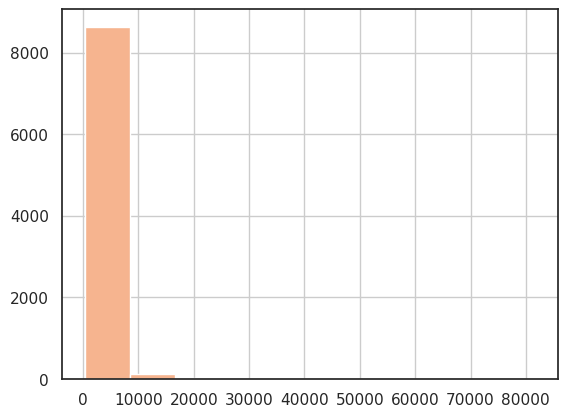

In [97]:
ax = attempt['diagnosisoffset'].hist()

Text(0.5, 12.44444444444443, 'Time until secondary MI (hours)')

<Figure size 640x480 with 0 Axes>

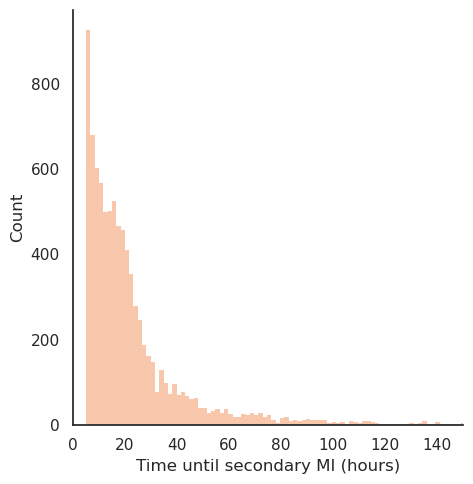

In [98]:
plt.figure()
sn.displot(attempt['diagnosisoffset']/(60))
plt.xlim([0, 150])
plt.xlabel('Time until secondary MI (hours)')

In [99]:
timeseries_aperiodic = pd.read_csv('Data/timeseries_aperiodic.csv', index_col=['patient', 'time'])
aperiodic = timeseries_processing(timeseries_aperiodic, attempt, 18)

In [100]:
timeseries_lab = pd.read_csv('Data/timeseries_lab.csv', index_col=['patient', 'time'])
lab = timeseries_processing(timeseries_lab, attempt, 18)

In [101]:
timeseries_resp = pd.read_csv('Data/timeseries_resp.csv', index_col=['patient', 'time'])
resp = timeseries_processing(timeseries_resp, attempt, 18)
mechanical_ventilation = list(resp.index)
values = [1] * len(mechanical_ventilation)
mechanical_vent_df = pd.DataFrame(values, mechanical_ventilation,
                                              columns =['mechanical_ventilation'])

In [102]:
final = merged_diagnosis.merge(labels, left_index=True, right_index=True)
final = final.merge(flats, left_index=True, right_index=True)
final = final.merge(aperiodic, left_index=True, right_index=True)
final = final.merge(mechanical_vent_df, left_index=True, right_index=True, how ="left")
final['mechanical_ventilation'] = final['mechanical_ventilation'].fillna(0)
final = final.merge(lab, left_index=True, right_index=True)

In [103]:
# Drop death as that is not a useful predictor for our application
#final = final.drop(columns=['actualhospitalmortality'])

# Keep only those patients that have had MI
final = final.drop(final[final.MI == 0].index)
final = final.drop(columns=['MI'])
final = final.drop(columns=['post_MI'])
final = final.merge(attempt, left_index=True, right_index=True)

In [104]:
final = final.drop(columns=['MI', 'diagnosisoffset', 'actualhospitalmortality'])

In [105]:
final

,unitdischargeoffset,predictedhospitalmortality,gender,age,admissionheight,admissionweight,hour,teachingstatus,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,unittype_CCU-CTICU,unittype_CSICU,unittype_CTICU,unittype_Cardiac ICU,unittype_MICU,unittype_Med-Surg ICU,unittype_Neuro ICU,unittype_SICU,unitadmitsource_Acute Care/Floor,unitadmitsource_Direct Admit,unitadmitsource_Emergency Department,unitadmitsource_Floor,unitadmitsource_Operating Room,unitadmitsource_Other Hospital,unitadmitsource_PACU,unitadmitsource_Recovery Room,unitadmitsource_Step-Down Unit (SDU),unitadmitsource_misc,unitvisitnumber_1,unitvisitnumber_2,unitvisitnumber_3,unitvisitnumber_misc,unitstaytype_admit,unitstaytype_readmit,unitstaytype_transfer,physicianspeciality_Specialty Not Specified,physicianspeciality_cardiology,physicianspeciality_critical care medicine (CCM),physicianspeciality_family practice,physicianspeciality_hospitalist,physicianspeciality_internal medicine,physicianspeciality_misc,physicianspeciality_neurology,physicianspeciality_other,physicianspeciality_pulmonary,physicianspeciality_pulmonary/CCM,physicianspeciality_surgery-cardiac,physicianspeciality_surgery-general,physicianspeciality_surgery-neuro,physicianspeciality_surgery-trauma,physicianspeciality_surgery-vascular,physicianspeciality_unknown,numbedscategory_100 - 249,numbedscategory_250 - 499,numbedscategory_<100,numbedscategory_>= 500,region_Midwest,region_Northeast,region_South,region_West,noninvasivesystolic_mean,noninvasivediastolic_mean,noninvasivemean_mean,noninvasivesystolic_std,noninvasivediastolic_std,noninvasivemean_std,mechanical_ventilation,-basos_mean,-eos_mean,-lymphs_mean,-monos_mean,-polys_mean,ALT (SGPT)_mean,AST (SGOT)_mean,BUN_mean,Base Excess_mean,FiO2_mean,HCO3_mean,Hct_mean,Hgb_mean,MCH_mean,MCHC_mean,MCV_mean,MPV_mean,O2 Sat (%)_mean,PT_mean,PT - INR_mean,PTT_mean,RBC_mean,RDW_mean,WBC x 1000_mean,albumin_mean,alkaline phos._mean,anion gap_mean,bedside glucose_mean,bicarbonate_mean,calcium_mean,chloride_mean,creatinine_mean,glucose_mean,lactate_mean,magnesium_mean,pH_mean,paCO2_mean,paO2_mean,phosphate_mean,platelets x 1000_mean,potassium_mean,sodium_mean,total bilirubin_mean,total protein_mean,troponin - I_mean,urinary specific gravity_mean,-basos_std,-eos_std,-lymphs_std,-monos_std,-polys_std,ALT (SGPT)_std,AST (SGOT)_std,BUN_std,Base Excess_std,FiO2_std,HCO3_std,Hct_std,Hgb_std,MCH_std,MCHC_std,MCV_std,MPV_std,O2 Sat (%)_std,PT_std,PT - INR_std,PTT_std,RBC_std,RDW_std,WBC x 1000_std,albumin_std,alkaline phos._std,anion gap_std,bedside glucose_std,bicarbonate_std,calcium_std,chloride_std,creatinine_std,glucose_std,lactate_std,magnesium_std,pH_std,paCO2_std,paO2_std,phosphate_std,platelets x 1000_std,potassium_std,sodium_std,total bilirubin_std,total protein_std,troponin - I_std,urinary specific gravity_std,post_MI
patient,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141168,3596,0.059099,0.0,70.0,152.4,84.30,15,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,108.500000,65.000000,66.200000,3.535534,4.242641,23.381617,1.0,0.000000,0.333333,11.666667,15.000000,73.0,529.000000,1731.333333,27.333333,NaN,64.000,13.500000,39.000000,12.566667,29.200000,32.166667,90.700000,NaN,NaN,27.100000,2.550000,32.500,4.306667,18.066667,14.766667,3.133333,145.666667,20.000000,NaN,22.000000,8.833333,101.333333,2.400000,93.333333,12.200000,2.000000,7.160000,39.500000,68.000000,7.9,203.000000,4.166667,139.333333,3.966667,6.833333,0.250000,NaN,0.00000,0.577350,6.658328,3.605551,10.440307,593.279867,2225.294213,1.527525,NaN,50.911688,1.732051,2.170253,1.021437,0.200000,0.873689,2.338803,NaN,NaN,12.388435,1.087811,4.949747,0.343851,0.208167,5.000333,0.152753,6.806859,5.000000,NaN,4.000000,0.351188,0.577350,0.507445,38.52

In [106]:
list(final.columns)

['unitdischargeoffset',
 'predictedhospitalmortality',
 'gender',
 'age',
 'admissionheight',
 'admissionweight',
 'hour',
 'teachingstatus',
 'ethnicity_African American',
 'ethnicity_Asian',
 'ethnicity_Caucasian',
 'ethnicity_Hispanic',
 'ethnicity_Native American',
 'ethnicity_Other/Unknown',
 'unittype_CCU-CTICU',
 'unittype_CSICU',
 'unittype_CTICU',
 'unittype_Cardiac ICU',
 'unittype_MICU',
 'unittype_Med-Surg ICU',
 'unittype_Neuro ICU',
 'unittype_SICU',
 'unitadmitsource_Acute Care/Floor',
 'unitadmitsource_Direct Admit',
 'unitadmitsource_Emergency Department',
 'unitadmitsource_Floor',
 'unitadmitsource_Operating Room',
 'unitadmitsource_Other Hospital',
 'unitadmitsource_PACU',
 'unitadmitsource_Recovery Room',
 'unitadmitsource_Step-Down Unit (SDU)',
 'unitadmitsource_misc',
 'unitvisitnumber_1',
 'unitvisitnumber_2',
 'unitvisitnumber_3',
 'unitvisitnumber_misc',
 'unitstaytype_admit',
 'unitstaytype_readmit',
 'unitstaytype_transfer',
 'physicianspeciality_Specialty No

In [107]:
pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_colwidth', 1000)  # or 199

# Missing values per feature
final.isnull().sum(axis = 0)/26012*100

unitdischargeoffset                                  0.000000
predictedhospitalmortality                           0.000000
gender                                               0.000000
age                                                  0.000000
admissionheight                                      0.000000
admissionweight                                      0.000000
hour                                                 0.000000
teachingstatus                                       0.000000
ethnicity_African American                           0.000000
ethnicity_Asian                                      0.000000
ethnicity_Caucasian                                  0.000000
ethnicity_Hispanic                                   0.000000
ethnicity_Native American                            0.000000
ethnicity_Other/Unknown                              0.000000
unittype_CCU-CTICU                                   0.000000
unittype_CSICU                                       0.000000
unittype

In [108]:
# Split the data into train and test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

X = final.drop('post_MI', axis=1, inplace=False).to_numpy()
y = final['post_MI'].to_numpy()

sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 7921 10064  7118 ... 21699  2930 16742] TEST: [ 5528 10059 12022 ...  3530 12514  3647]


In [109]:
np.save('Revised Experiments/X_train_static_MI_18', X_train)
np.save('Revised Experiments/X_test_static_MI_18', X_test)
np.save('Revised Experiments/y_train_static_MI_18', y_train)
np.save('Revised Experiments/y_test_static_MI_18', y_test)

In [16]:
X_train_static_6[5, :]

array([0.00000000e+00, 6.69000000e+02, 1.42889220e-02, 1.00000000e+00,
       6.20000000e+01, 1.72700000e+02, 6.89000000e+01, 1.10000000e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [6]:
X_train_static_6 = np.load('Revised Experiments/X_train_static_6.npy')
X_test_static_6 = np.load('Revised Experiments/X_test_static_6.npy')
y_train_static_6 = np.load('Revised Experiments/y_train_static_6.npy')
y_test_static_6 = np.load('Revised Experiments/y_test_static_6.npy')

In [7]:
# Train and test split
np.shape(X_train_static_6), np.shape(X_test_static_6)

((20974, 164), (5244, 164))

In [8]:
# LOS distribution
print((np.mean(X_train_static_6[:,1])/(60*24), np.std(X_train_static_6[:,1])/(60*24), np.median(X_train_static_6[:,1])/(60*24)))
print(np.mean(X_test_static_6[:,1])/(60*24), np.std(X_test_static_6[:,1])/(60*24), np.median(X_test_static_6[:,1])/(60*24))

(2.9731449585730485, 3.7520513662700505, 1.8447916666666666)
2.9967468111704383 3.895494807283556 1.8722222222222222


In [14]:
# Women vs Men distribution
unique, counts = np.unique(X_train_static_6[:,3], return_counts=True)
result = dict(zip(unique, counts))
print(result)

unique, counts = np.unique(X_test_static_6[:,3], return_counts=True)
result = dict(zip(unique, counts))
print(result)

{0.0: 7604, 0.5: 1, 1.0: 13369}
{0.0: 1859, 1.0: 3385}


In [17]:
# Age distribution
print(np.mean(X_train_static_6[:,4]), np.std(X_train_static_6[:,4]), np.median(X_train_static_6[:,4]))
print(np.mean(X_test_static_6[:,4]), np.std(X_test_static_6[:,4]), np.median(X_test_static_6[:,4]))

66.80709449794985 12.682954054934662 68.0
66.75896262395118 12.759924038626735 68.0


In [11]:
# Death distribution
unique, counts = np.unique(y_train_static_6, return_counts=True)
result = dict(zip(unique, counts))
print(result)

unique, counts = np.unique(y_test_static_6, return_counts=True)
result = dict(zip(unique, counts))
print(result)

{0: 18463, 1: 2511}
{0: 4616, 1: 628}


In [21]:
y_train_static_6 = np.load('Revised Experiments/y_train_static_MI_6.npy')
y_test_static_6 = np.load('Revised Experiments/y_test_static_MI_6.npy')

In [22]:
# MI distribution
unique, counts = np.unique(y_train_static_6, return_counts=True)
result = dict(zip(unique, counts))
print(result)

unique, counts = np.unique(y_test_static_6, return_counts=True)
result = dict(zip(unique, counts))
print(result)

{0: 15193, 1: 5616}
{0: 3799, 1: 1404}
